POI QA Notebook
Goal: Verify completeness, correctness, consistency, and stability of POI features at Ortsteil level.
Outputs: - per_1k normalized POIs
         - anomaly tables (nulls, negatives, outliers, inconsistencies)
         - lightweight QA report CSV

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

sns.set(style="whitegrid", context="notebook")

# Load
df = pd.read_csv("../../data/processed/ortsteil_master_with_poi.csv")

# Identifiers & groups
id_cols = ["bezirk","ortsteil"]
pop_col = "total_population"

poi_cols = [
    'alcohol','animal_training','antiques','art','bar','bathing_place','books','butcher','childcare','clothes',
    'community_centre','confectionery','convenience','deli','dog_park','electronics','fitness_station','florist',
    'fountain','games','garden','greenfield','greengrocer','hairdresser','ice_cream','kiosk','marina',
    'nature_reserve','nightclub','parking','pitch','playground','restaurant','second_hand','stationery','supermarket',
    'theatre','travel_agency','vacant','wine','yes','cafes','bakeries','green_space','schools','medical'
]

# Optional references (if present)
ref_cols = [c for c in ["classification_category","subdistrict_avg_median_income_eur",
                        "subdistrict_avg_mietspiegel_classification"] if c in df.columns]

In [4]:
# 2.1 Basic schema
display(df[id_cols + [pop_col] + poi_cols].head(3))
print("Rows:", len(df), "| Unique ortsteil:", df['ortsteil'].nunique())

# 2.2 Uniqueness by ortsteil
dups = (df
        .groupby("ortsteil")
        .size()
        .reset_index(name="rows_per_ortsteil")
        .query("rows_per_ortsteil > 1"))
dups.head(10)

# 2.3 Missing identifiers / population
key_missing = df[df[id_cols + [pop_col]].isna().any(axis=1)][id_cols + [pop_col]]
key_missing.head(10)

,bezirk,ortsteil,total_population,alcohol,animal_training,antiques,art,bar,bathing_place,books,...,theatre,travel_agency,vacant,wine,yes,cafes,bakeries,green_space,schools,medical
0,treptow-koepenick,adlershof,20210,0,0,0,0,2,0,0,...,0,0,0,0,1,11,1,215,17,8
1,lichtenberg,alt-hohenschoenhausen,50070,0,0,0,0,7,0,0,...,0,0,0,0,0,9,0,375,38,8
2,treptow-koepenick,alt-treptow,13167,0,0,0,0,3,0,0,...,0,0,0,0,0,13,1,183,13,5


Rows: 96 | Unique ortsteil: 96


,bezirk,ortsteil,total_population


In [5]:
# 3.1 Nulls per column (sorted)
nulls = df[id_cols].copy()
for c in [pop_col] + poi_cols:
    nulls[c] = df[c].isna()
nulls_summary = nulls[[pop_col] + poi_cols].mean().sort_values(ascending=False).to_frame("null_rate")
nulls_summary.head(15)

# 3.2 Negatives or non-integers for raw POIs (they should be counts)
negatives = []
non_ints = []
for c in poi_cols:
    if (df[c].dropna() < 0).any():
        negatives.append(c)
    # allow floats that are integer-like (e.g., 3.0)
    m = df[c].dropna()
    if not np.allclose(m, np.round(m)):
        non_ints.append(c)
negatives, non_ints

# 3.3 Population sanity
df.loc[(df[pop_col].isna()) | (df[pop_col] <= 0), id_cols + [pop_col]].head(10)

,bezirk,ortsteil,total_population


In [6]:
df_norm = df[id_cols + [pop_col] + poi_cols].copy()
df_norm[pop_col] = df_norm[pop_col].replace({0: np.nan})  # avoid div-by-zero
for c in poi_cols:
    df_norm[c + "_per_1k"] = 1000 * df_norm[c] / df_norm[pop_col]

per1k_cols = [c + "_per_1k" for c in poi_cols]
df_norm = df_norm[id_cols + per1k_cols]
df = df.merge(df_norm, on=id_cols, how="left")

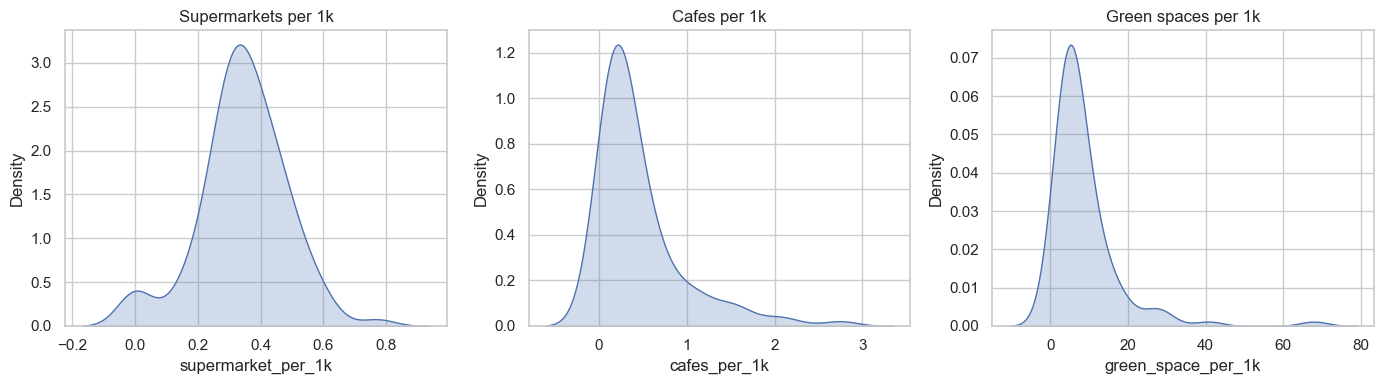

In [7]:
# 5.1 Basic stats
stats = df[per1k_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
stats.sort_values("mean", ascending=False).head(10)

# 5.2 Z-score outliers (loose threshold)
outlier_tables = {}
for c in per1k_cols:
    z = zscore(df[c].fillna(df[c].median()))
    mask = np.abs(z) > 3
    if mask.any():
        outlier_tables[c] = df.loc[mask, id_cols + [c]].sort_values(c, ascending=False)

# Example: supermarkets and cafes outliers
outlier_tables.get("supermarket_per_1k", pd.DataFrame()).head(10)
outlier_tables.get("cafes_per_1k", pd.DataFrame()).head(10)

# 5.3 Visual check for a few popular POIs
fig, axes = plt.subplots(1,3, figsize=(14,4))
sns.kdeplot(data=df, x="supermarket_per_1k", ax=axes[0], fill=True)
axes[0].set_title("Supermarkets per 1k")

sns.kdeplot(data=df, x="cafes_per_1k", ax=axes[1], fill=True)
axes[1].set_title("Cafes per 1k")

sns.kdeplot(data=df, x="green_space_per_1k", ax=axes[2], fill=True)
axes[2].set_title("Green spaces per 1k")
plt.tight_layout(); plt.show()

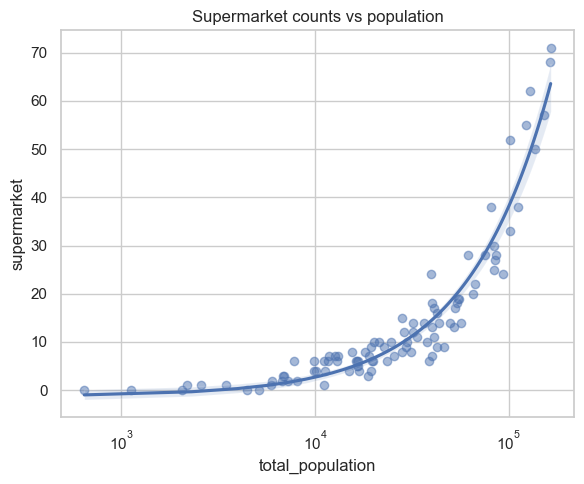

,food_share,bezirk,ortsteil
13,0.480606,charlottenburg-wilmersdorf,charlottenburg
31,0.445545,charlottenburg-wilmersdorf,halensee
56,0.411181,mitte,mitte
68,0.354699,pankow,prenzlauer berg
43,0.333333,reinickendorf,konradshoehe
44,0.312256,friedrichshain-kreuzberg,kreuzberg
93,0.309735,charlottenburg-wilmersdorf,wilmersdorf
23,0.297809,friedrichshain-kreuzberg,friedrichshain
57,0.281390,mitte,moabit
61,0.274240,neukoelln,neukoelln


In [8]:
# 6.1 Amenity richness (sum of per_1k). Look for impossible extremes.
df["amenity_richness"] = df[per1k_cols].sum(axis=1)
df.sort_values("amenity_richness", ascending=False)[id_cols + ["amenity_richness"]].head(10)

# 6.2 Size effects: raw counts vs population (should be positively related)
plt.figure(figsize=(6,5))
sns.regplot(data=df, x=pop_col, y="supermarket", scatter_kws={"alpha":0.5})
plt.xscale("log"); plt.title("Supermarket counts vs population"); plt.tight_layout(); plt.show()

# 6.3 Share-of-POIs sanity (optional): e.g., F&B share among selected POIs
food_cols = ["supermarket","cafes","bakeries","restaurant","confectionery","ice_cream","greengrocer"]
df["food_share"] = df[food_cols].sum(axis=1) / df[poi_cols].sum(axis=1)
df.loc[df["food_share"].notna(), ["food_share"] + id_cols].sort_values("food_share", ascending=False).head(10)

/Users/didodeboodt/Documents/Projects/Berlin_Housing_Affordability/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


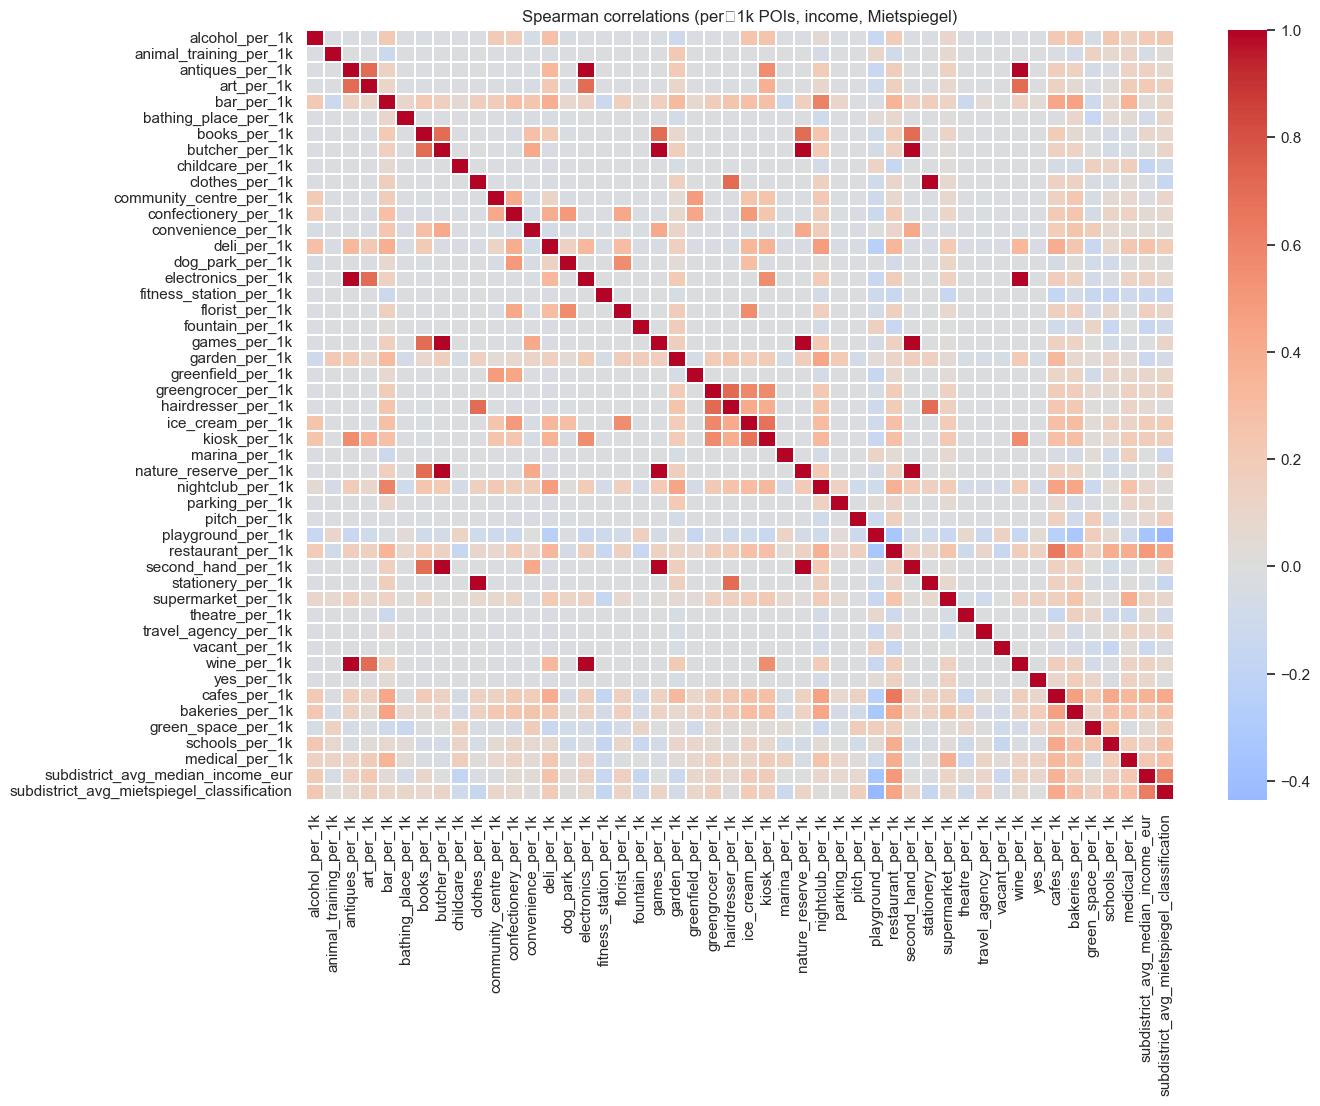

In [12]:
corr_cols = per1k_cols + [c for c in ref_cols if "income" in c or "mietspiegel" in c]
corr = df[corr_cols].corr(method="spearman")
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=.2)
plt.title("Spearman correlations (per‑1k POIs, income, Mietspiegel)")

plt.show()

In [13]:
flags = pd.DataFrame()
flags[id_cols] = df[id_cols]

# Flag rules
flags["missing_pop"]      = df[pop_col].isna() | (df[pop_col] <= 0)
flags["poi_any_null"]     = df[poi_cols].isna().any(axis=1)
flags["poi_any_negative"] = (df[poi_cols] < 0).any(axis=1)
flags["amenity_rich_gt_p95"] = df["amenity_richness"] > df["amenity_richness"].quantile(0.95)
flags["amenity_rich_lt_p05"] = df["amenity_richness"] < df["amenity_richness"].quantile(0.05)

# Optional: add a couple of specific extreme POIs
for col in ["supermarket_per_1k","cafes_per_1k","green_space_per_1k"]:
    if col in df.columns:
        flags[f"{col}_gt_p99"] = df[col] > df[col].quantile(0.99)

flags["any_flag"] = flags.drop(columns=id_cols).any(axis=1)

anomalies = flags[flags["any_flag"]].merge(df[id_cols + [pop_col] + poi_cols + per1k_cols], on=id_cols, how="left")
print("Anomalous rows:", len(anomalies), "of", len(df))

# Save report (optional)
anomalies.to_csv("poi_anomaly_report.csv", index=False)

Anomalous rows: 12 of 96
